**MODELO 2: PREVISIÓN DE CANCELACIONES PARA GESTAMP**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import re
# from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report

In [2]:
general = pd.read_csv("opportunities_general_data_202404261638.csv", sep = ',',on_bad_lines='skip', encoding='latin-1')
general_cleaned = general.drop(columns=['deletedBy', 'deletedOn', 'createdBy', 'modifiedBy', 'modifiedOn', 'investmentsComments', 'keySuccessFactors'])
sales = pd.read_csv("opportunities_sales_202404261640.csv", sep=',' ,  index_col=0, encoding='ISO-8859-1')
sales_cleaned = sales.drop(columns=['commercialStrategy','comments','awardedTo', 'awardedDate','createdBy', 'deletedBy','deletedOn', 'intercompany_ManagementCompany_code'])
cancellation_reasons = pd.read_csv("opportunity_sale_cancellation_reasons_202405021504.csv", sep=',')

In [3]:
general_cleaned["iD"] = general_cleaned.iD.apply(lambda x: str(x)).astype(str)
sales_cleaned["opportunityId"] = sales_cleaned.opportunityId.apply(lambda x: str(x).split(".")[0]).astype(str)

In [4]:
general_cleaned["iD"] = general_cleaned.iD.apply(lambda x: str(x)).astype(str) #antes de la transformacion nos aseguramos que los ids estén en el mismo formato
sales_cleaned["opportunityId"] = sales_cleaned.opportunityId.apply(lambda x: str(x).split(".")[0]).astype(str)

sales_gen = pd.merge(sales_cleaned, general_cleaned, left_on="opportunityId", right_on="iD")
sales_gen.info()
#filtramos el cruce teniendo en cuenta solo ventas canceladas y ventas awarded, obviando las demás categorías
df = sales_gen[sales_gen['saleStatus'].isin(['Cancelled', 'Awarded'])] #total de 3107 filas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116 entries, 0 to 5115
Data columns (total 54 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   businessType                         5116 non-null   object 
 1   cancelDate                           1663 non-null   object 
 2   dateOnWhichTheRecordWasCreated_x     5116 non-null   object 
 3   currency                             5116 non-null   object 
 4   divisionStrategy                     5116 non-null   object 
 5   effectiveMonth                       2324 non-null   float64
 6   hasLTA                               5116 non-null   object 
 7   hasQuickSavings                      5116 non-null   object 
 8   Id                                   5116 non-null   float64
 9   inBusinessPlan                       5116 non-null   object 
 10  inBusinessPlanRevision               1796 non-null   object 
 11  inBusinessPlanYear            

In [5]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(df).T

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
businessType,object,0.0,2,0.06
cancelDate,object,46.48,396,12.75
dateOnWhichTheRecordWasCreated_x,object,0.0,1796,57.8
currency,object,0.0,10,0.32
divisionStrategy,object,0.0,4,0.13
effectiveMonth,float64,56.03,12,0.39
hasLTA,object,0.0,2,0.06
hasQuickSavings,object,0.0,2,0.06
Id,float64,0.0,3107,100.0


In [6]:
df_copy = df.copy()

**Creación de nuevas columnas**

In [7]:
# Columnas a eliminar
columns_to_drop = [
    'cancelDate', 'effectiveMonth', 'opportunity_desc', 'dateOnWhichTheRecordWasCreated_y',
    'opportunityId_y', 'versionID_y', 'lostDate', 'modifiedBy', 'modifiedOn', 
    'managementCompany_code', 'intercompany_ManagementCompany_desc', 'saleId', 'turnoverSOP2', 
    'turnoverSOP2Euros', 'versionID_x', 'divisionStrategy', 'iD', 'oEM_code', 
    'automotiveCompanyCode', 'opportunityYear', 'closingComments', 'opportunityId_x', 
    'managementCompany_desc', 'quickSavingsDiscountCurrency', 'expectedInitialRFQDate', 
    'strategicRelevance', 'lTAType', 'yearInvestmentStarted', 'closingDate', 'businessUnit_code',
    'inBusinessPlanYear', 'valueAdded', 'quickSavingsType', 'inBusinessPlanRevision','totalInvestmentCurrency', 'currency', 'pricePerVehicleEuros', 'hasQuickSavings', 'pricePerVehicleLocalCurrency'
] 

df_copy = df_copy.drop(columns=columns_to_drop)

#conservaremos Id porque lo necesitamos para el segundo feature engineering, donde haremos un merge con nuestra tabla de cancelaciones

In [8]:
#Campos que necesitamos: dateOnWhichTheRecordWasCreated_x y expectedAwardDate (aplicaremos time delta para conocer el tiempo transcurrido)

# Limpiamos y preparamos el ID y opportunityId
# general_cleaned["iD"] = general_cleaned.iD.apply(lambda x: str(x)).astype(str)
# sales_cleaned["opportunityId"] = sales_cleaned.opportunityId.apply(lambda x: str(x).split(".")[0]).astype(str)

# Realizamos el join
# df = pd.merge(sales_cleaned, general_cleaned, left_on="opportunityId", right_on="iD")

# Extraemos y transformamos las fechas del formato trimestral
valid_dates = []
for date in df_copy['expectedAwardDate']:
    if re.match(r'Q[1-4]\d{4}', date):
        valid_dates.append(date)

valid_dates_df = pd.DataFrame(valid_dates, columns=['expectedAwardDate'])
valid_dates_df["date"] = pd.to_datetime(valid_dates_df["expectedAwardDate"].apply(
    lambda x: x.replace("Q1", "31-03-").replace("Q2", "30-06-").replace("Q3", "30-09-").replace("Q4", "31-12-")),
    format='%d-%m-%Y'
)

# Asignamos fechas convertidas de vuelta a sales_gen para alinear
df_copy = df_copy.assign(expectedAwardDate_converted=valid_dates_df['date'].values)

# Convertimos las fechas de creación a datetime si no lo están
df_copy["dateOnWhichTheRecordWasCreated_x"] = pd.to_datetime(df_copy["dateOnWhichTheRecordWasCreated_x"])

# Calculamos el delta de tiempo en meses
df_copy['time_delta_months'] = (df_copy['expectedAwardDate_converted'] - df_copy['dateOnWhichTheRecordWasCreated_x']) / pd.Timedelta(days=30)

# Preparar datos para el gráfico
# time_data = sales_gen[['dateOnWhichTheRecordWasCreated_x', 'time_delta_months']].dropna()
# time_data = time_data.sort_values(by='dateOnWhichTheRecordWasCreated_x')

In [9]:
columns_to_drop = [
    'expectedAwardDate','dateOnWhichTheRecordWasCreated_x', 'expectedAwardDate_converted'
] 
df_copy = df_copy.drop(columns=columns_to_drop)

In [11]:
categorical_columns = [
    'businessType', 'hasLTA', 'inBusinessPlan', 
    'saleType', 'saleStatus', 'designResponsible', 'hasInvestments', 
    'opportunityStatus'
]

# Aplicar One Hot Encoding
df_encoded = pd.get_dummies(df_copy, columns=categorical_columns)
df_encoded.head()

,Id,pricePerVehicle,annualAverageTotalPlanning,probabilityOfAward,automotiveCompanyName,time_delta_months,businessType_Growth,businessType_Replacement,hasLTA_No,hasLTA_Yes,...,saleType_Intercompany,saleStatus_Awarded,saleStatus_Cancelled,designResponsible_False,designResponsible_True,hasInvestments_false,hasInvestments_true,opportunityStatus_Closed,opportunityStatus_Open,opportunityStatus_Pending Close
0,2097268.0,160.0,0,75,Mercedes-Benz,19.572839,False,True,False,True,...,False,False,True,True,False,True,False,True,False,False
1,2097269.0,45.0,0,75,Mercedes-Benz,19.572839,False,True,False,True,...,True,False,True,True,False,True,False,True,False,False
2,2097270.0,120.0,0,75,Mercedes-Benz,19.572839,False,True,False,True,...,False,False,True,True,False,True,False,True,False,False
3,2097271.0,35.0,0,75,Mercedes-Benz,19.572839,False,True,False,True,...,True,False,True,True,False,True,False,True,False,False
4,2097272.0,65.0,0,75,Mercedes-Benz,19.572839,False,True,True,False,...,False,False,True,True,False,False,True,True,False,False


In [12]:
# Mapeo de las variables categóricas a valores numéricos
mapping_dict = {
    'businessType': {'Replacement': 0, 'Growth': 1},
    'hasLTA': {'Yes': 1, 'No': 0},
    'hasQuickSavings': {'Yes': 1, 'No': 0},
    'inBusinessPlan': {'Yes': 1, 'No': 0},
    'saleType': {'External Sales': 0, 'Intercompany': 1},
    'saleStatus': {'Awarded': 0, 'Cancelled': 1},
    'designResponsible': {False: 0, True: 1},
    'hasInvestments': {'true': 1, 'false': 0},
    'opportunityStatus': {'Open': 0, 'Closed': 1, 'Pending Close': 2}
}

# Asignar valores numéricos según el mapeo
df_copy = df_copy.replace(mapping_dict)

# Mostrar las primeras filas del DataFrame transformado para verificación
df_copy.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5408\1968301726.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy = df_copy.replace(mapping_dict)


,businessType,hasLTA,Id,inBusinessPlan,pricePerVehicle,saleType,saleStatus,annualAverageTotalPlanning,designResponsible,hasInvestments,probabilityOfAward,opportunityStatus,automotiveCompanyName,time_delta_months
0,0,1,2097268.0,1,160.0,0,1,0,0,0,75,1,Mercedes-Benz,19.572839
1,0,1,2097269.0,1,45.0,1,1,0,0,0,75,1,Mercedes-Benz,19.572839
2,0,1,2097270.0,1,120.0,0,1,0,0,0,75,1,Mercedes-Benz,19.572839
3,0,1,2097271.0,1,35.0,1,1,0,0,0,75,1,Mercedes-Benz,19.572839
4,0,0,2097272.0,1,65.0,0,1,0,0,1,75,1,Mercedes-Benz,19.572839


In [13]:
# Definir las compañías más populares
popular_companies = [
    'STELLANTIS', 'Volkswagen', 'Renault/Nissan', 'Tata-JLR', 
    'Ford', 'Mercedes-Benz', 'Toyota', 'BMW'
]

# Crear columnas para las compañías populares y una columna para "otros"
for company in popular_companies:
    df_copy[company] = df_copy['automotiveCompanyName'].apply(lambda x: 1 if x == company else 0)

# Crear la columna "otros"
df_copy['Otros'] = df_copy['automotiveCompanyName'].apply(lambda x: 0 if x in popular_companies else 1)

In [14]:
columns_to_drop = [
    'automotiveCompanyName'
] 
df_copy = df_copy.drop(columns=columns_to_drop)

Merge con cancellation_reasons

In [15]:
cancellation_reasons['saleId'] = cancellation_reasons['saleId'].astype(str)
df_copy["Id"] = df_copy.Id.apply(lambda x: str(x).split(".")[0]).astype(str)


In [16]:
# Realizar el merge
merged_df = pd.merge(df_copy, cancellation_reasons, left_on='Id', right_on='saleId', how='left')

merged_df.head()


,businessType,hasLTA,Id,inBusinessPlan,pricePerVehicle,saleType,saleStatus,annualAverageTotalPlanning,designResponsible,hasInvestments,...,Renault/Nissan,Tata-JLR,Ford,Mercedes-Benz,Toyota,BMW,Otros,saleId,versionID,cancellationReassonName
0,0,1,2097268,1,160.0,0,1,0,0,0,...,0,0,0,1,0,0,0,2097268,457.0,Cancelled by customer after completion/submission
1,0,1,2097269,1,45.0,1,1,0,0,0,...,0,0,0,1,0,0,0,2097269,457.0,Cancelled by customer after completion/submission
2,0,1,2097270,1,120.0,0,1,0,0,0,...,0,0,0,1,0,0,0,2097270,457.0,Cancelled by customer after completion/submission
3,0,1,2097271,1,35.0,1,1,0,0,0,...,0,0,0,1,0,0,0,2097271,457.0,Cancelled by customer after completion/submission
4,0,0,2097272,1,65.0,0,1,0,0,1,...,0,0,0,1,0,0,0,2097272,457.0,Cancelled by customer after completion/submission


In [17]:
#eliminamos los ids que necesitábamos para hacer el merge
columns_to_drop = ['Id', 'saleId','versionID'] 
merged_df = merged_df.drop(columns=columns_to_drop)

In [18]:
merged_df["cancellationReassonName"].value_counts()

cancellationReassonName
Cancelled by customer before completion/submission               540
Cancelled by customer after completion/submission                278
Mistake                                                          246
Customer cancelled vehicle replacement                           157
Quote was combined with others at customer request               143
Customer was conducting a market test                             59
Customer nominated alternative technology                         39
Insufficient Capacity to support business                         38
Requoted within GMS at a later date                               35
Logistical disadvantage                                           32
High Piece Price                                                  30
Gestamp has not been included in bid list                         24
The typology of the parts does not match Gestamp's facilities     18
Customer made strategic nomination                                16
Delayed re

In [19]:
#transformamos los motivos, en vez de tener valores booleanos asignamos 1 y 0

# Definir palabras clave
keywords = {
    "Cancelled by customer before completion/submission": "cancelled_before_completion",
    "Cancelled by customer after completion/submission": "cancelled_after_completion",
    "Mistake": "mistake",
    "Customer cancelled vehicle replacement": "cancelled_vehicle_replacement",
    "Quote was combined with others at customer request": "combined_quote",
    "Customer was conducting a market test": "market_test",
    "Customer nominated alternative technology": "alternative_technology",
    "Insufficient Capacity to support business": "insufficient_capacity",
    "Requoted within GMS at a later date": "requote_later_date",
    "Logistical disadvantage": "logistical_disadvantage",
    "High Piece Price": "high_price"
}

# Crear una copia del DataFrame para trabajar
df_copy = merged_df.copy()

# Mapear los motivos de cancelación a las palabras clave
df_copy['cancellationReasonKeyword'] = df_copy['cancellationReassonName'].map(keywords)

# Aplicar get_dummies a la columna cancellationReasonKeyword
df_encoded = pd.get_dummies(df_copy, columns=['cancellationReasonKeyword'])

# Renombrar las columnas generadas para que coincidan con los nombres de las palabras clave
new_column_names = {f"cancellationReasonKeyword_{key}": key for key in set(keywords.values()).union(['otros'])}
df_encoded.rename(columns=new_column_names, inplace=True)

# Convertir columnas booleanas a enteros (True -> 1, False -> 0)
boolean_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   businessType                   3113 non-null   int64  
 1   hasLTA                         3113 non-null   int64  
 2   inBusinessPlan                 3113 non-null   int64  
 3   pricePerVehicle                3113 non-null   float64
 4   saleType                       3113 non-null   int64  
 5   saleStatus                     3113 non-null   int64  
 6   annualAverageTotalPlanning     3113 non-null   int64  
 7   designResponsible              3113 non-null   int64  
 8   hasInvestments                 3113 non-null   int64  
 9   probabilityOfAward             3113 non-null   object 
 10  opportunityStatus              3113 non-null   int64  
 11  time_delta_months              3113 non-null   float64
 12  STELLANTIS                     3113 non-null   i

In [21]:
columns_to_drop = ['cancellationReassonName'
] 

df_encoded = df_encoded.drop(columns=columns_to_drop)

In [22]:
df_encoded

,businessType,hasLTA,inBusinessPlan,pricePerVehicle,saleType,saleStatus,annualAverageTotalPlanning,designResponsible,hasInvestments,probabilityOfAward,...,cancelled_after_completion,cancelled_before_completion,cancelled_vehicle_replacement,combined_quote,high_price,insufficient_capacity,logistical_disadvantage,market_test,mistake,requote_later_date
0,0,1,1,160.0,0,1,0,0,0,75,...,1,0,0,0,0,0,0,0,0,0
1,0,1,1,45.0,1,1,0,0,0,75,...,1,0,0,0,0,0,0,0,0,0
2,0,1,1,120.0,0,1,0,0,0,75,...,1,0,0,0,0,0,0,0,0,0
3,0,1,1,35.0,1,1,0,0,0,75,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,65.0,0,1,0,0,1,75,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,1,1,0,105.0,0,1,92727,0,1,50,...,0,0,0,0,0,0,0,0,1,0
3109,1,0,0,50.0,0,1,79888,0,1,25,...,0,0,0,0,0,0,0,0,1,0
3110,1,0,0,50.0,0,1,79888,0,1,25,...,0,1,0,0,0,0,0,0,0,0
3111,1,0,0,40.0,0,1,192419,0,1,25,...,0,0,0,0,0,1,0,0,0,0


In [23]:
data_report(df_encoded).T #df final

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
businessType,int64,0.0,2,0.06
hasLTA,int64,0.0,2,0.06
inBusinessPlan,int64,0.0,2,0.06
pricePerVehicle,float64,0.0,1699,54.58
saleType,int64,0.0,2,0.06
saleStatus,int64,0.0,2,0.06
annualAverageTotalPlanning,int64,0.0,895,28.75
designResponsible,int64,0.0,2,0.06
hasInvestments,int64,0.0,2,0.06


In [24]:
df_encoded.to_csv('df_encoded.csv', index=False)

**Matriz de correlación**

<Axes: >

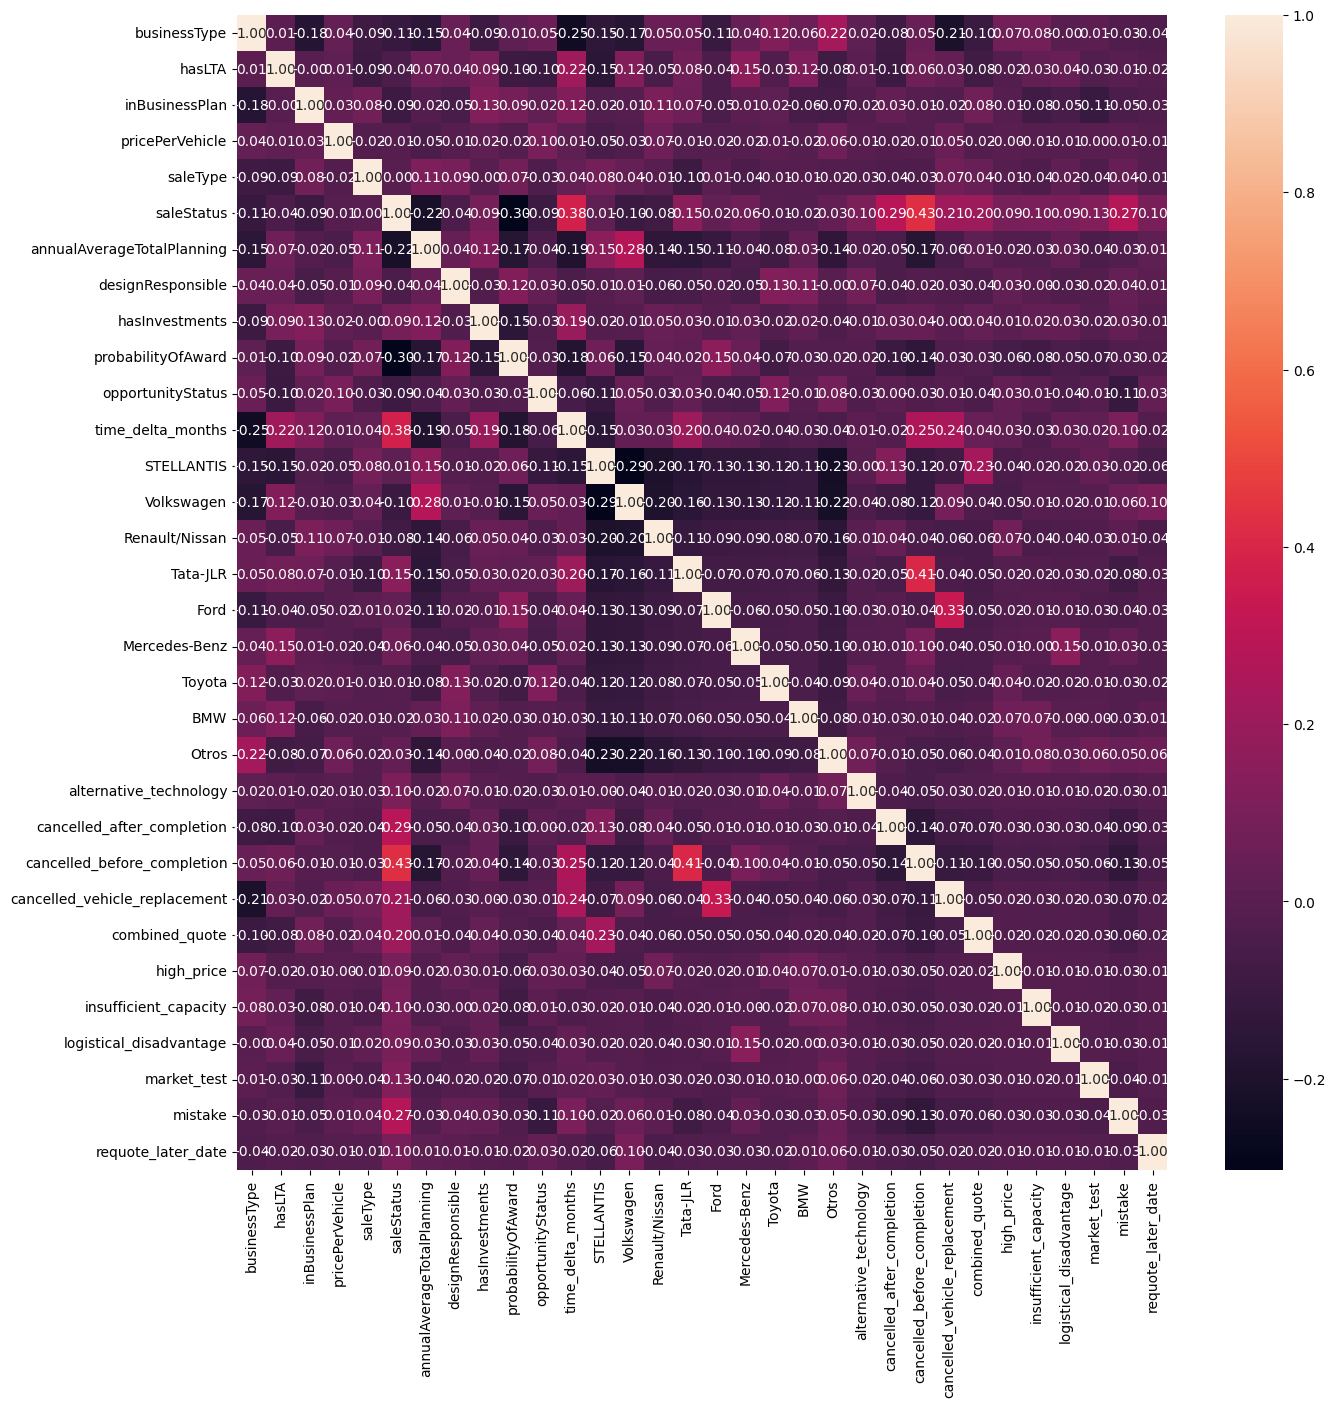

In [42]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_encoded.corr(), annot=True, fmt='.2f')

-**cancelled_after_completion** y **cancelled_before_completion** tienen bastante correlación con nuestro target.

-Los clientes **Tata-JLR** y **Ford** tienen correlación con **cancelled_before_completion** y **cancelled_vehicle_replacement** respectivamente. 

-**time_delta_months** tiene cierta correlación con **cancelled_after_completion** y **cancelled_before_completion**.

-El motivo de cancelación por error (**mistake**) tiene cierta relación con nuestro target.

-**time_delta_months** correla con nuestro target (y con **cancelled_before_completion**)

-**AnnualAveragegTotalPlanning** y **probabilityofAward** correlan negativamente con nuestro target.





In [52]:
df_encoded.describe()

,businessType,hasLTA,inBusinessPlan,pricePerVehicle,saleType,saleStatus,annualAverageTotalPlanning,designResponsible,hasInvestments,opportunityStatus,...,cancelled_after_completion,cancelled_before_completion,cancelled_vehicle_replacement,combined_quote,high_price,insufficient_capacity,logistical_disadvantage,market_test,mistake,requote_later_date
count,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3.113000e+03,3113.000000,3113.000000,3113.000000,...,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000
mean,0.627369,0.438805,0.496627,1077.263206,0.095728,0.536139,1.402797e+05,0.091230,0.912624,1.064889,...,0.089303,0.173466,0.050434,0.045936,0.009637,0.012207,0.010279,0.018953,0.079023,0.011243
std,0.483583,0.496321,0.500069,10551.393388,0.294265,0.498772,1.930048e+05,0.287983,0.282430,0.356221,...,0.285226,0.378711,0.218873,0.209381,0.097710,0.109826,0.100881,0.136380,0.269819,0.105453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,1.795700e+04,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,42.000000,0.000000,1.000000,7.045500e+04,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,200.000000,0.000000,1.000000,1.803930e+05,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,336809.000000,1.000000,1.000000,1.321008e+06,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**División entre train y test y normalización**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_encoded.drop('saleStatus', axis=1)  # Suponiendo que 'saleStatus' es la variable objetivo
y = df_encoded['saleStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el MinMaxScaler
scaler = MinMaxScaler()

# Ajustar el scaler solo con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Convertir los datos escalados a DataFrames si se desea
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


print(X_train_scaled.describe())
print(X_test_scaled.describe())

       businessType       hasLTA  inBusinessPlan  pricePerVehicle  \
count   2179.000000  2179.000000     2179.000000      2179.000000   
mean       0.625975     0.439192        0.491510         0.003086   
std        0.483981     0.496403        0.500043         0.029276   
min        0.000000     0.000000        0.000000         0.000000   
25%        0.000000     0.000000        0.000000         0.000023   
50%        1.000000     0.000000        0.000000         0.000120   
75%        1.000000     1.000000        1.000000         0.000588   
max        1.000000     1.000000        1.000000         1.000000   

          saleType  annualAverageTotalPlanning  designResponsible  \
count  2179.000000                 2179.000000        2179.000000   
mean      0.094080                    0.105559           0.091326   
std       0.292007                    0.147866           0.288139   
min       0.000000                    0.000000           0.000000   
25%       0.000000               

In [26]:
X.shape,y.shape

((3113, 31), (3113,))

**Gridsearch de modelos y optimización del mejor**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [28]:
pipe = Pipeline(steps=[
    ('classifier', LinearRegression())
])

logistic_params = {
    'classifier': [LogisticRegression()],
}

random_forest_params = {
    'classifier': [RandomForestClassifier()],
}
extra_trees = {
    'classifier': [ExtraTreesClassifier()],
}

ada_param = {
    'classifier': [AdaBoostClassifier()],
}

gbc_param = {
    'classifier': [GradientBoostingClassifier()],
}

xgb_param = {
    'classifier': [XGBClassifier()],
}

KNC_param = {
    'classifier': [KNeighborsClassifier()],
}

search_space = [
    logistic_params,
    random_forest_params,
    extra_trees,
    ada_param,
    gbc_param,
    xgb_param,
    KNC_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  n_jobs= -1,
                  cv = 10)

clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()]},
                         {'classifier': [RandomForestClassifier()]},
                         {'classifier': [ExtraTreesClassifier()]},
                         {'classifier': [AdaBoostClassifier()]},
                         {'classifier': [GradientBoostingClassifier()]},
                         {'classifier': [XGBClassifier(base_score=Non...
                                                       interaction_constraints=None,
                                                       learning_rate=None,
                                                       max_bin=None,
                                                       max_cat_threshold=None,
                                                       max_cat_to_onehot=None,
                                                       max_delta_step=None,
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=None, ...)]},
                         {'classifier': [KNeighborsClassifier()]}])

In [29]:
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('classifier', ExtraTreesClassifier())])
0.9825624656491778
{'classifier': ExtraTreesClassifier()}


In [31]:
et = ExtraTreesClassifier()

params = {"n_estimators": [50, 100, 150, 200, 300],
          "max_depth": [5,7,9],
          "random_state": [42]}

et_et = GridSearchCV(estimator=et,
                      param_grid=params,
                      n_jobs=-1,
                      cv=10,
                      scoring="f1")

et_et.fit(X_train_scaled, y_train)
et_et.best_estimator_

ExtraTreesClassifier(max_depth=9, n_estimators=300, random_state=42)

In [32]:
et_fin= ExtraTreesClassifier(max_depth=9, n_estimators=300, random_state=42)
et_fin.fit(X_train_scaled,y_train)
predictions = et_fin.predict(X_test_scaled)
et_score=f1_score(y_test,predictions)
et_acc= accuracy_score(y_test,predictions)

In [34]:
predictions = et_fin.predict(X_test_scaled)
et_score= f1_score(y_test,predictions)
et_acc= accuracy_score(y_test,predictions)
print(f"F1 Score de Extra Tree modelo 2: {et_score}")
print(f"Accuracy de Extra Tree modelo 2: {et_acc}")

F1 Score de Extra Tree modelo 2: 0.9724208375893769
Accuracy de Extra Tree modelo 2: 0.9710920770877944


F1 Score de 0.972: Nuestro modelo tiene buen equilibrio entre la precisión y la sensibilidad.

Exactitud de 0.971: Nuestro modelo es muy preciso en general, prediciendo correctamente el estado de cancelación en el 97.1% de los casos.

In [ ]:
#### abandonamos la idea, es demasiado costoso computacionalmente###
#en un principio el extratrees parece ser el mejor modelo. Sin embargo, decidimos optimizar los demás modelos para asegurarnos escoger el mejor.

In [55]:
# import pandas as pd
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
# from sklearn.neighbors import KNeighborsClassifier

# # Suponiendo que tienes tus datos ya divididos en X_train, y_train

# # Definir los modelos y sus hiperparámetros
# models_gridsearch = {
#     'LogisticRegression': GridSearchCV(LogisticRegression(), param_grid={'C': [0.1, 1, 10]}, cv=10),
#     'RandomForest': GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [50, 100, 150], 'max_depth': [5, 7, 9]}, cv=10),
#     'ExtraTrees': GridSearchCV(ExtraTreesClassifier(), param_grid={'n_estimators': [50, 100, 150], 'max_depth': [5, 7, 9]}, cv=10),
#     'AdaBoost': GridSearchCV(AdaBoostClassifier(), param_grid={'n_estimators': [50, 100, 150]}, cv=10),
#     'GradientBoosting': GridSearchCV(GradientBoostingClassifier(), param_grid={'n_estimators': [50, 100, 150], 'max_depth': [5, 7, 9]}, cv=10),
#     'XGBoost': GridSearchCV(XGBClassifier(), param_grid={'n_estimators': [50, 100, 150], 'max_depth': [5, 7, 9]}, cv=10),
#     'KNeighbors': GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [3, 5, 7, 9]}, cv=10)
# }

# # Entrenar los modelos y obtener los mejores puntajes
# best_grids = []
# for name, model in models_gridsearch.items():
#     model.fit(X_train_scaled, y_train)
#     best_grids.append((name, model.best_score_))

# # Crear el DataFrame
# best_grids_df = pd.DataFrame(best_grids, columns=["Model", "Best score"]).sort_values(by="Best score", ascending=False)

# # Mostrar el DataFrame
# best_grids_df


c:\Users\Usuario\.conda\envs\ML-ENV\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Usuario\.conda\envs\ML-ENV\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Usuario\.conda\envs\ML-ENV\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Usuario\.conda\envs\ML-ENV\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

                Model  Best score
4    GradientBoosting    0.986232
5             XGBoost    0.983021
3            AdaBoost    0.979347
0  LogisticRegression    0.978430
2          ExtraTrees    0.966958
1        RandomForest    0.954105
6          KNeighbors    0.899028


In [56]:
# best_grids_df

,Model,Best score
4,GradientBoosting,0.986232
5,XGBoost,0.983021
3,AdaBoost,0.979347
0,LogisticRegression,0.978430
2,ExtraTrees,0.966958
1,RandomForest,0.954105
6,KNeighbors,0.899028


**Métricas obtenidas con ExtraTreesClassifier**

In [60]:
et_fin= ExtraTreesClassifier(max_depth=9, n_estimators=50, random_state=42)
et_fin.fit(X_train_scaled,y_train)
predictions = et_fin.predict(X_test_scaled)
et_score=f1_score(y_test,predictions)
et_acc= accuracy_score(y_test,predictions)
c_matrix = confusion_matrix(y_test, predictions)

In [36]:
df_encoded.columns

Index(['businessType', 'hasLTA', 'inBusinessPlan', 'pricePerVehicle',
       'saleType', 'saleStatus', 'annualAverageTotalPlanning',
       'designResponsible', 'hasInvestments', 'probabilityOfAward',
       'opportunityStatus', 'time_delta_months', 'STELLANTIS', 'Volkswagen',
       'Renault/Nissan', 'Tata-JLR', 'Ford', 'Mercedes-Benz', 'Toyota', 'BMW',
       'Otros', 'alternative_technology', 'cancelled_after_completion',
       'cancelled_before_completion', 'cancelled_vehicle_replacement',
       'combined_quote', 'high_price', 'insufficient_capacity',
       'logistical_disadvantage', 'market_test', 'mistake',
       'requote_later_date'],
      dtype='object')

**Feature Importance**

In [38]:
feature_importances= random_f.feature_importances_
feature_importances

array([0.00597792, 0.00609157, 0.00682324, 0.01285379, 0.01914168,
       0.01876022, 0.01756286, 0.00087713, 0.13200244, 0.00140026,
       0.00156634, 0.05622771, 0.00815651, 0.12146597, 0.00397294,
       0.0065706 , 0.00567271, 0.00689129, 0.00105267, 0.00117818,
       0.00035302, 0.00101187, 0.00245998, 0.01045262, 0.11081469,
       0.19404064, 0.04414739, 0.06232257, 0.00574182, 0.00941261,
       0.00625065, 0.01772799, 0.09406694, 0.00695119])

In [39]:
feature_importance_df = pd.DataFrame({'Columna': X.columns, 'Importancia': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False).reset_index()
# feature_importance_df = feature_importance_df.drop('index',axis=1)
feature_importance_df

,index,Columna,Importancia
0,25,cancelled_before_completion,0.194041
1,8,annualAverageTotalPlanning,0.132002
2,13,time_delta_months,0.121466
3,24,cancelled_after_completion,0.110815
4,32,mistake,0.094067
5,27,combined_quote,0.062323
6,11,probabilityOfAward,0.056228
7,26,cancelled_vehicle_replacement,0.044147
8,4,pricePerVehicle,0.019142
9,5,pricePerVehicleEuros,0.018760


In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


**Matriz de confusión**

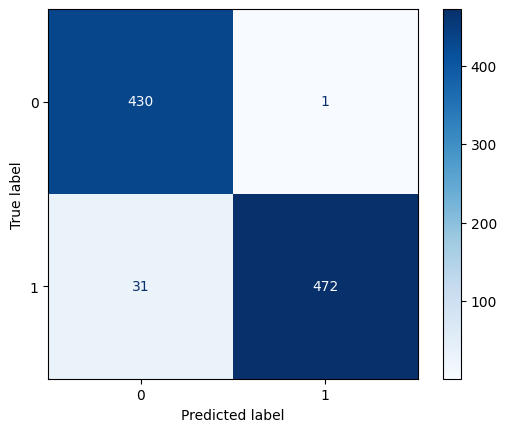

In [41]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, predictions, labels=random_f.classes_)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_f.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


True Positive (TP): 472
Estos son los casos en los que el modelo predijo que una oportunidad se cancelaría (1) y efectivamente se canceló.

True Negative (TN): 430
Estos son los casos en los que el modelo predijo que una oportunidad no se cancelaría (0) y efectivamente no se canceló.

False Positive (FP): 1
Estos son los casos en los que el modelo predijo que una oportunidad se cancelaría (1), pero en realidad no se canceló (0). También se conoce como un "falso positivo".

False Negative (FN): 31
Estos son los casos en los que el modelo predijo que una oportunidad no se cancelaría (0), pero en realidad se canceló (1). También se conoce como un "falso negativo".